In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os

In [2]:
################################'Generate regressor X from an AR(1)'##############################
################################ Xt = α + βXt-1 + εt

T_x =100;  # sample size
df = pd.DataFrame(index=range(T_x), columns=['x', 'y', 'epsilon_y' ])
alpha_x = 1;    # intercept parameter
beta_x = 0.9;   # autoregressive parameter
sigma_x = 0.1;  # standard error of innovations
x1 = alpha_x/(1-beta_x) # define initial value for time series x

epsilon_x = sigma_x*np.random.randn(T_x); # generate a vector of T random normal
df.iloc[0,:] = [x1] # initialize x

for i in range(0, T_x-1):
    df.iloc[i+1,0] = alpha_x + beta_x * df.iloc[i,0] + epsilon_x[i+1] # generate X(t) recursively
    # Xt = α + βXt-1 + εt
print(df['x'])

0          10.0
1     10.258849
2     10.198585
3     10.099187
4     10.076072
        ...    
95    10.148252
96    10.012962
97     9.990336
98     9.984026
99     9.928442
Name: x, Length: 100, dtype: object


In [3]:
################################ Generate Y ##############################
################################ # Yt = α + + βXt + εt + θεt-1

T_y = 100 
alpha_y = 1
beta_y = 0.9
theta_y = 0.5
sigma_y = 0.1
epsilon_y = sigma_y*np.random.randn(T_y,1)
y1 = 0
df['y'] = 0

for j in range(0, T_y-1):
    df.iloc[j+1,1] = alpha_y + beta_y * df.iloc[j+1,0] + epsilon_y[j] + theta_y * epsilon_y[j-1]
    # Yt = α + βYt-1 + γXt + εt + θεt-1

print(df)


            x          y epsilon_y
0        10.0   0.000000      10.0
1   10.258849  10.191286       NaN
2   10.198585  10.112970       NaN
3   10.099187  10.132015       NaN
4   10.076072  10.038256       NaN
..        ...        ...       ...
95  10.148252  10.142167       NaN
96  10.012962  10.031525       NaN
97   9.990336   9.845838       NaN
98   9.984026   9.701033       NaN
99   9.928442   9.924146       NaN

[100 rows x 3 columns]


In [4]:
import statsmodels.formula.api as smf

# Fit quantile regression 
y = df['y'].values.astype(float)
x = df['x'].values.astype(float)
T=100
sigma = 0.5;  # standard error of innovations
epsilon = sigma*np.random.randn(T,1)
df['epsilon'] = epsilon

epsilon = df['epsilon'].values.astype(float)
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon, 1)
epsilon_lag[0] = 0
alpha = 6
beta = 0.3
gamma = 0.9
theta = 0.5


#quant_reg_1 = sm.QuantReg(y, alpha_+ beta * y_lag + gamma * x).fit(q=0.1)
#quant_reg_5 = sm.QuantReg(y, alpha + beta * y_lag + gamma * x).fit(q=0.5)
#quant_reg_9 = sm.QuantReg(y, alpha + beta * y_lag + gamma * x).fit(q=0.9)

quant_reg_1 = sm.QuantReg(y, alpha + beta * y_lag + gamma * x + epsilon + theta * epsilon_lag).fit(q=0.1)
quant_reg_5 = sm.QuantReg(y, alpha + beta * y_lag + gamma * x + epsilon + theta * epsilon_lag).fit(q=0.5)
quant_reg_9 = sm.QuantReg(y, alpha + beta * y_lag + gamma * x + epsilon + theta * epsilon_lag).fit(q=0.9)

# Print the summary of the quantile regression results
print(quant_reg_1.summary())
print(quant_reg_5.summary())
print(quant_reg_9.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:             -0.01506
Model:                       QuantReg   Bandwidth:                      0.3891
Method:                 Least Squares   Sparsity:                        1.795
Date:                Tue, 18 Apr 2023   No. Observations:                  100
Time:                        10:23:30   Df Residuals:                       99
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5322      0.003    171.216      0.000       0.526       0.538
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:              -0.2695
Model:                       QuantReg   Bandwidth:  

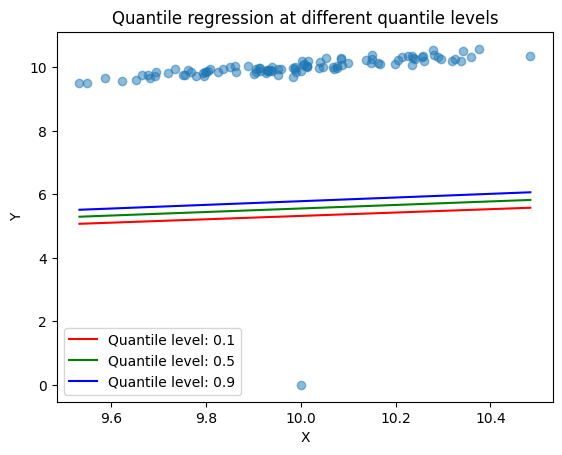

In [5]:
################################ Quantile regression plot ##############################
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
# Create a scatter plot of the data
plt.scatter(x, y, alpha=0.5)

# Plot the quantile regression lines at different quantile levels
x_sort = np.sort(x)
y_pred_1 = quant_reg_1.predict(x_sort)
y_pred_5 = quant_reg_5.predict(x_sort)
y_pred_9 = quant_reg_9.predict(x_sort)

plt.plot(x_sort, y_pred_1, color='red', label='Quantile level: 0.1')
plt.plot(x_sort, y_pred_5, color='green', label='Quantile level: 0.5')
plt.plot(x_sort, y_pred_9, color='blue', label='Quantile level: 0.9')

# Add a legend and labels to the plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Quantile regression at different quantile levels')
plt.show()


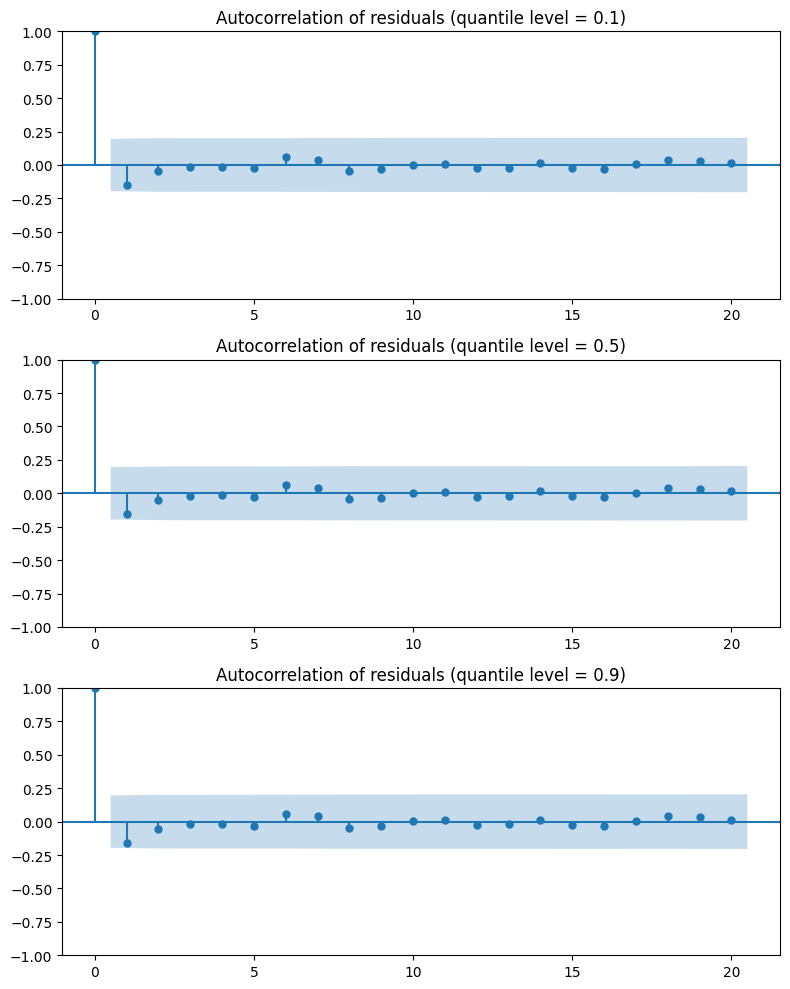

In [6]:
################################ Autocorrelation of the residuals ##############################
residuals_1 = quant_reg_1.resid # Calculate the residuals
residuals_5 = quant_reg_5.resid # Calculate the residuals
residuals_9 = quant_reg_9.resid # Calculate the residuals

# Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
fig, ax = plt.subplots(3, 1, figsize=(8, 10))
plot_acf(quant_reg_1.resid, ax=ax[0])
ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
plot_acf(quant_reg_5.resid, ax=ax[1])
ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
plot_acf(quant_reg_9.resid, ax=ax[2])
ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
plt.tight_layout()
plt.show()

#Autocorrelation fades away as the lags increase



In [7]:
################################ OLS estimation of the parameters ##############################
# Add lagged values of Y and epsilon
y_lag = np.roll(y, 1)
y_lag[0] = 0
epsilon_lag = np.roll(epsilon_y, 1)
epsilon_lag[0] = 0

# Construct the design matrix
X = np.column_stack((np.ones_like(x), y_lag, x, epsilon_lag))

# Estimate the parameters
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Print the parameter estimates
print("alpha_hat_OLS = {:.4f}".format(beta_hat[0]))
print("beta_hat_OLS = {:.4f}".format(beta_hat[1]))
print("gamma_hat_OLS = {:.4f}".format(beta_hat[2]))
print("theta_hat_OLS = {:.4f}".format(beta_hat[3]))

actuals = [6, 0.3,  0.9, 0.5] # True parameters alpha, beta, gamma, theta

def print_parameters_and_biases(beta, actuals):
    for i, beta_ in enumerate(beta):
        print(f"param_GLS_{i} = {beta_:.4f}")

    biases = actuals - beta # Calculate the biases
    for i, bias in enumerate(biases):
        print(f"bias_param_GLS_{i} = {bias:.4f}")
    
    mse = np.mean(np.square(biases)) # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f"RMSE = {rmse:.4f}")
print_parameters_and_biases(beta_hat, actuals)


alpha_hat_OLS = -3.0717
beta_hat_OLS = 0.4913
gamma_hat_OLS = 0.8164
theta_hat_OLS = 0.4935
param_GLS_0 = -3.0717
param_GLS_1 = 0.4913
param_GLS_2 = 0.8164
param_GLS_3 = 0.4935
bias_param_GLS_0 = 9.0717
bias_param_GLS_1 = -0.1913
bias_param_GLS_2 = 0.0836
bias_param_GLS_3 = 0.0065
RMSE = 4.5371


In [8]:
################################ GLS estimation of the parameters ##############################
resid = y - X @ beta_hat# Compute the residuals

acf_resid, ci = sm.tsa.stattools.acf(resid, nlags=1, alpha=0.05) # Compute the ACF of the residuals

# Estimate the covariance parameters
sigma2 = np.var(resid) * (1 - acf_resid[1]) #variance of the residuals removing the effect of this correlation on the variance
sigma2_array = np.full(T, sigma2)
rho = acf_resid[1] / (1 - acf_resid[1]) #correlation between adjacent residuals
#covariance matrix S: variance on the diagonal and the correlation on the off-diagonal elements
S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
print(S)
# Compute the GLS estimator 
beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y

# Print the parameter estimates
actuals = [6, 0.3,  0.9, 0.5] #alpha, beta, gamma, theta
print_parameters_and_biases(beta_gls, actuals)

[[ 0.76385024 -0.253114    0.         ...  0.          0.
   0.        ]
 [-0.253114    0.76385024 -0.253114   ...  0.          0.
   0.        ]
 [ 0.         -0.253114    0.76385024 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.76385024 -0.253114
   0.        ]
 [ 0.          0.          0.         ... -0.253114    0.76385024
  -0.253114  ]
 [ 0.          0.          0.         ...  0.         -0.253114
   0.76385024]]
param_GLS_0 = -0.9828
param_GLS_1 = 0.4702
param_GLS_2 = 0.6292
param_GLS_3 = 0.6040
bias_param_GLS_0 = 6.9828
bias_param_GLS_1 = -0.1702
bias_param_GLS_2 = 0.2708
bias_param_GLS_3 = -0.1040
RMSE = 3.4955


In [9]:
################################ GLS estimation of the parameters ##############################
residuals = y - X @ beta_hat# Compute the residuals
#Estimate the covariance matrix of the errors
sigma_hat = np.cov(residuals, rowvar=False)
print(sigma_hat)

0.5158951873450964
